<a href="https://colab.research.google.com/github/PRATYUSHA1309/MY-PROJECTS/blob/main/hugging_face_text_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HUGGING FACE TEXT CLASSIFICATION

* RESOURCE NOTE BOOK : https://www.learnhuggingface.com/notebooks/hugging_face_text_classification_tutorial
* SETUP STEPS: https://www.learnhuggingface.com/extras/setup

NOTE : A GPU IS NEEDED ON GOOGLE COLAB

## IMPORTNG NECESSARY LIBRARIES

In [1]:
# Install dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## GETTING DATASET


In [2]:
# Load the dataset from Hugging Face Hub
dataset = datasets.load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")

# Inspect the dataset
dataset

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [3]:
# What features are there?
dataset.column_names


{'train': ['text', 'label']}

In [4]:
# Access the training split
dataset["train"]


Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [5]:
import random

random_indexs = random.sample(range(len(dataset["train"])), 5)
random_samples = dataset["train"][random_indexs]

print(f"[INFO] Random samples from dataset:\n")
for item in zip(random_samples["text"], random_samples["label"]):
    print(f"Text: {item[0]} | Label: {item[1]}")

[INFO] Random samples from dataset:

Text: Watching TV together, a family has their dog stretched out on the floor | Label: not_food
Text: Brussels sprouts in a bowl, sprinkled with bacon bits and served with a side of maple syrup for a savory, sweet dish. | Label: food
Text: Fragrant vegetable curry with coconut milk and spices, featuring a mix of tender vegetables in a rich, aromatic sauce. | Label: food
Text: A bowl of sliced dragon fruit with a sprinkle of coconut flakes and a drizzle of lime juice | Label: food
Text: Artichokes in a bowl, sprinkled with garlic and served with a side of lemon aioli for a tasty, sophisticated dish. | Label: food


In [6]:
# Get unique label values
dataset["train"].unique("label")

['food', 'not_food']

In [7]:
# Check number of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'food': 125, 'not_food': 125})

In [8]:
# Turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset["train"])
food_not_food_df.sample(7)

,text,label
75,"Sushi with a spicy kick, featuring jalapeno pe...",food
224,Stainless steel refrigerator with a convenient...,not_food
59,A white car parked in a driveway with a wooden...,not_food
166,Fusion sushi roll with ingredients like cream ...,food
2,"Watching TV together, a family has their dog s...",not_food
121,Set of stainless steel utensils arranged on a ...,not_food
198,Set of straws held in a holder,not_food


In [9]:
# Get the value counts of the label column
food_not_food_df["label"].value_counts()

,count
label,
food,125
not_food,125


# Preparing data for text classification


In [10]:
# Create mapping from id2label and label2id
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


In [11]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset["train"].unique("label")[::-1])} # reverse sort list to have "not_food" first
label2id = {label: idx for idx, label in id2label.items()}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


In [12]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

example_sample = {"text": "This is a sentence about my favourite food: honey.", "label": "food"}

# Test the function
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favourite food: honey.', 'label': 1}

In [13]:
# Map our dataset labels to numbers
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [14]:
# Shuffle the dataset and view the first 5 samples (will return different results each time)
dataset.shuffle()[:5]

{'text': ['Uniquely presented sushi roll, such as a hand roll or sushi burrito.',
  'A close-up shot of a big orange pumpkin with a face cut out of the side for Halloween.',
  'Fennel in a bowl, sprinkled with lemon zest and served with a side of olive oil for a light, refreshing dish.',
  'White bathtub with a shower curtain ready for a soak',
  'Tangy tomato curry with chicken, featuring tender chicken pieces in a zesty tomato-based sauce with onions and spices.'],
 'label': [1, 1, 1, 0, 1]}

In [15]:
# Create train/test splits
dataset = dataset.train_test_split(test_size=0.2, seed=42) # note: seed isn't needed, just here for reproducibility, without it you will get different splits each time you run the cell
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [16]:
random_idx_train = random.randint(0, len(dataset["train"]))
random_sample_train = dataset["train"][random_idx_train]

random_idx_test = random.randint(0, len(dataset["test"]))
random_sample_test = dataset["test"][random_idx_test]

print(f"[INFO] Random sample from training dataset:")
print(f"Text: {random_sample_train['text']}\nLabel: {random_sample_train['label']} ({id2label[random_sample_train['label']]})\n")
print(f"[INFO] Random sample from testing dataset:")
print(f"Text: {random_sample_test['text']}\nLabel: {random_sample_test['label']} ({id2label[random_sample_test['label']]})")

[INFO] Random sample from training dataset:
Text: Sushi roll with premium ingredients like uni or wagyu beef.
Label: 1 (food)

[INFO] Random sample from testing dataset:
Text: A fruit platter with a variety of exotic fruits, such as dragon fruit, mangosteen, and durian
Label: 1 (food)


# Tokenizing text data

In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True) # uses fast tokenization (backed by tokenziers library and implemented in Rust) by default, if not available will default to Python implementation

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [18]:
# Test out tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [19]:
# Try adding a "!" at the end
tokenizer("I love pizza!")

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [20]:
# Get the length of the vocabulary
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"Length of tokenizer vocabulary: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

Length of tokenizer vocabulary: 30522
Max tokenizer input sequence length: 512


In [21]:
# Does "daniel" occur in the vocab?
tokenizer.vocab["daniel"]

3817

In [22]:
tokenizer.vocab["pizza"]

10733

In [23]:
# Get the length of the vocabulary
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"Length of tokenizer vocabulary: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

Length of tokenizer vocabulary: 30522
Max tokenizer input sequence length: 512


In [24]:
# Does "daniel" occur in the vocab?
tokenizer.vocab["daniel"]

3817

In [25]:
tokenizer.vocab["pizza"]

10733

In [26]:
tokenizer("akash")

{'input_ids': [101, 9875, 4095, 102], 'attention_mask': [1, 1, 1, 1]}

In [27]:
tokenizer.convert_ids_to_tokens(tokenizer("akash").input_ids)

['[CLS]', 'aka', '##sh', '[SEP]']

In [28]:
# Try to tokenize an emoji
tokenizer.convert_ids_to_tokens(tokenizer("🍕").input_ids)

['[CLS]', '[UNK]', '[SEP]']

In [29]:
# Get the first 5 items in the tokenizer vocab
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

In [30]:
import random

random.sample(sorted(tokenizer.vocab.items()), k=5)

[('magnesium', 24983),
 ('sw', 25430),
 ('traitor', 17328),
 ('1200', 14840),
 ('mississippi', 5900)]

# Making a preprocessing function to tokenize text

In [31]:
def tokenize_text(examples):
    """
    Tokenize given example text and return the tokenized text.
    """
    return tokenizer(examples["text"],
                     padding=True, # pad short sequences to longest sequence in the batch
                     truncation=True) # truncate long sequences to the maximum length the model can handle

In [32]:
example_sample_2 = {"text": "I love pizza", "label": 1}

# Test the function
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [33]:
# Map our tokenize_text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to operate across batches of examples rather than only single examples
                                batch_size=1000) # defaults to 1000, can be increased if you have a large dataset

tokenized_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [35]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

# Setting up an evaluation metric

In [36]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [37]:
# Create example list of predictions and labels
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


In [38]:
# Get id and label mappings
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

id2label: {0: 'not_food', 1: 'food'}
label2id: {'not_food': 0, 'food': 1}


In [39]:
from transformers import AutoModelForSequenceClassification

# Setup model for fine-tuning with classification head (top layers of network)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=2, # can customize this to the number of classes in your dataset
    id2label=id2label, # mappings from class IDs to the class labels (for classification tasks)
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# Try and make a prediction with the loaded model (this will error)
model(**tokenized_dataset["train"][0])

TypeError: DistilBertForSequenceClassification.forward() got an unexpected keyword argument 'text'

In [41]:
# Inspect the model
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

#  Counting the parameters of our model

In [42]:
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

# Count the parameters of the model
count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

In [43]:
# Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

In [44]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

# Create training arguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch", # was previously "evaluation_strategy"
    save_strategy="epoch",
    save_total_limit=3, # limit the total amount of save checkpoints (so we don't save num_epochs checkpoints)
    use_cpu=False, # set to False by default, will use CUDA GPU or MPS device if available
    seed=42, # set to 42 by default for reproducibility
    load_best_model_at_end=True, # load the best model when finished training
    logging_strategy="epoch", # log training results every epoch
    report_to="none", # optional: log experiments to Weights & Biases/other similar experimenting tracking services (we'll turn this off for now)
    # push_to_hub=True # optional: automatically upload the model to the Hub (we'll do this manually later on)
    # hub_token="your_token_here" # optional: add your Hugging Face Hub token to push to the Hub (will default to huggingface-cli login)
    hub_private_repo=False # optional: make the uploaded model private (defaults to False)
)

# Optional: Print out training_args to inspect (warning, it is quite a long output)
# training_args

[INFO] Saving model checkpoints to: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [45]:
from transformers import Trainer

# Setup Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    # Note: the 'tokenizer' parameter will be changed to 'processing_class' in Transformers v5.0.0
    tokenizer=tokenizer, # Pass tokenizer to the Trainer for dynamic padding (padding as the training happens) (see "data_collator" in the Trainer docs)
    compute_metrics=compute_accuracy
)

<ipython-input-45-a2fafd012213>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train a text classification model
results = trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
# Inspect training metrics
for key, value in results.metrics.items():
    print(f"{key}: {value}")

In [ ]:
# Save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [ ]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1] # get everything except the training time metrics (we've seen these already)
trainer_history_training_time = trainer_history_all[-1] # this is the same value as results.metrics from above

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 0.387,
  'grad_norm': 1.1924431324005127,
  'learning_rate': 9.142857142857143e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.0559685043990612,
  'eval_accuracy': 1.0,
  'eval_runtime': 2.7009,
  'eval_samples_per_second': 18.512,
  'eval_steps_per_second': 0.74,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0267,
  'grad_norm': 0.11059292405843735,
  'learning_rate': 8.142857142857143e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.0066800545901060104,
  'eval_accuracy': 1.0,
  'eval_runtime': 2.6774,
  'eval_samples_per_second': 18.675,
  'eval_steps_per_second': 0.747,
  'epoch': 2.0,
  'step': 14}]

In [ ]:
import pprint # import pretty print for nice printing of lists

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 1.1924431324005127,
  'learning_rate': 9.142857142857143e-05,
  'loss': 0.387,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.11059292405843735,
  'learning_rate': 8.142857142857143e-05,
  'loss': 0.0267,
  'step': 14}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.0559685043990612,
  'eval_runtime': 2.7009,
  'eval_samples_per_second': 18.512,
  'eval_steps_per_second': 0.74,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.0066800545901060104,
  'eval_runtime': 2.6774,
  'eval_samples_per_second': 18.675,
  'eval_steps_per_second': 0.747,
  'step': 14}]


In [ ]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.3870,1.192443,0.000091,1.0,7
1,0.0267,0.110593,0.000081,2.0,14
2,0.0044,0.040650,0.000071,3.0,21
3,0.0018,0.025627,0.000061,4.0,28
4,0.0021,0.019260,0.000051,5.0,35


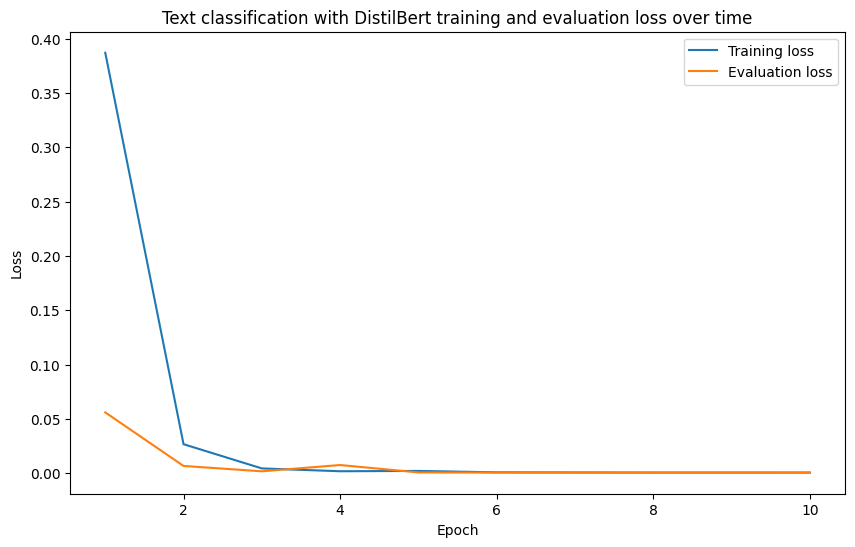

In [ ]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()

In [ ]:
# Save our model to the Hugging Face Hub
# This will be public, since we set hub_private_repo=False in our TrainingArguments
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model",
    # token="YOUR_HF_TOKEN_HERE" # This will default to the token you have saved in your Hugging Face config
)
print(f"[INFO] Model successfully uploaded to Hugging Face Hub with at URL: {model_upload_url}")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

[INFO] Model successfully uploaded to Hugging Face Hub with at URL: https://huggingface.co/Praty13/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/tree/main/


In [ ]:
# Perform predictions on the test set
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
prediction_metrics

[INFO] Prediction metrics on the test data:


{'test_loss': 0.0004434861184563488,
 'test_accuracy': 1.0,
 'test_runtime': 2.8962,
 'test_samples_per_second': 17.264,
 'test_steps_per_second': 0.691}

In [ ]:
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities (this is optional, could get the same results with step 2 onwards)
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = dataset["test"]["label"]

# 4. Compare predicted labels to true labels to get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}%")

[INFO] Test accuracy: 100.0%


In [ ]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999553
1,Red brick fireplace with a mantel serving as a...,0,0,0.999506
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999547
3,Set of mugs hanging on a hook,0,0,0.999605
4,Standing floor lamp providing light next to an...,0,0,0.999592


In [ ]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
43,Set of muffin tins stacked together,0,0,0.999418
1,Red brick fireplace with a mantel serving as a...,0,0,0.999506
19,"Spicy chickpea curry bowl, featuring nutty chi...",1,1,0.999541
41,"Sushi with a spicy kick, featuring jalapeno pe...",1,1,0.999542
45,"Green beans in a bowl, sprinkled with almonds ...",1,1,0.999542
36,"Vibrant red curry with tofu and bell peppers, ...",1,1,0.999543
37,"Close-up of a sushi roll with avocado, cucumbe...",1,1,0.999543
5,A bowl of sliced tomatoes with a sprinkle of b...,1,1,0.999544
9,Cherry tomatoes and mozzarella balls in a bowl...,1,1,0.999544
10,"Creamy spinach and potato curry, featuring flu...",1,1,0.999544


In [ ]:
# Setup local model path
local_model_path = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Setup Hugging Face model path (see: https://huggingface.co/mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased)
# Note: Be sure to change "mrdbourke" to your own Hugging Face username
huggingface_model_path = "mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

In [ ]:
def set_device():
    """
    Set device to CUDA if available, else MPS (Mac), else CPU.

    This defaults to using the best available device (usually).
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cpu


In [ ]:
import torch
from transformers import pipeline

# Set the batch size for predictions
BATCH_SIZE = 32

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task="text-classification", # we can use this because our model is an instance of AutoModelForSequenceClassification
                                    model=local_model_path, # could also pass in huggingface_model_path
                                    device=DEVICE, # set the target device
                                    top_k=1, # only return the top predicted value
                                    batch_size=BATCH_SIZE) # perform predictions on up to BATCH_SIZE number of samples at a time

food_not_food_classifier

Device set to use cpu


In [ ]:
# Test our trained model on some example text
sample_text_food = "A delicious photo of a plate of scrambled eggs, bacon and toast"
food_not_food_classifier(sample_text_food)

[[{'label': 'food', 'score': 0.9995450377464294}]]

In [ ]:
# Test the model on some more example text
sample_text_not_food = "A yellow tractor driving over the hill"
food_not_food_classifier(sample_text_not_food)

[[{'label': 'not_food', 'score': 0.9995546936988831}]]

In [ ]:
# Pass in random text to the model
food_not_food_classifier("cvnhertiejhwgdjshdfgh394587")

[[{'label': 'not_food', 'score': 0.9989604949951172}]]

In [ ]:
# Pipeline also works with remote models (will have to laod the model locally first)
food_not_food_classifier_remote = pipeline(task="text-classification",
                                           model=huggingface_model_path, # load the model from Hugging Face Hub (will download the model if it doesn't already exist)
                                           batch_size=BATCH_SIZE,
                                           device=DEVICE)

food_not_food_classifier_remote("This is some new text about bananas and pancakes and ice cream")

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'food', 'score': 0.9993979930877686}]

In [ ]:
# Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[[{'label': 'not_food', 'score': 0.9971613883972168}],
 [{'label': 'not_food', 'score': 0.9990090131759644}],
 [{'label': 'not_food', 'score': 0.9981355667114258}],
 [{'label': 'not_food', 'score': 0.9984449744224548}],
 [{'label': 'not_food', 'score': 0.9985916018486023}],
 [{'label': 'not_food', 'score': 0.9974480867385864}],
 [{'label': 'not_food', 'score': 0.9554160237312317}],
 [{'label': 'food', 'score': 0.9995278120040894}],
 [{'label': 'not_food', 'score': 0.9994611144065857}],
 [{'label': 'not_food', 'score': 0.8366958498954773}]]

In [ ]:
import time

# Create 1000 sentences
sentences_1000 = sentences * 100

# Time how long it takes to make predictions on all sentences (one at a time)
print(f"[INFO] Number of sentences: {len(sentences_1000)}")
start_time_one_at_a_time = time.time()
for sentence in sentences_1000:
    # Make a prediction on each sentence one at a time
    food_not_food_classifier(sentence)
end_time_one_at_a_time = time.time()

print(f"[INFO] Time taken for one at a time prediction: {end_time_one_at_a_time - start_time_one_at_a_time} seconds")
print(f"[INFO] Avg inference time per sentence: {(end_time_one_at_a_time - start_time_one_at_a_time) / len(sentences_1000)} seconds")

[INFO] Number of sentences: 1000
[INFO] Time taken for one at a time prediction: 76.40519618988037 seconds
[INFO] Avg inference time per sentence: 0.07640519618988037 seconds


In [ ]:
for i in [10, 100, 1000, 10_000]:
    sentences_big = sentences * i
    print(f"[INFO] Number of sentences: {len(sentences_big)}")

    start_time = time.time()
    # Predict on all sentences in batches
    food_not_food_classifier(sentences_big)
    end_time = time.time()

    print(f"[INFO] Inference time for {len(sentences_big)} sentences: {round(end_time - start_time, 5)} seconds.")
    print(f"[INFO] Avg inference time per sentence: {round((end_time - start_time) / len(sentences_big), 8)} seconds.")
    print()

[INFO] Number of sentences: 100
[INFO] Inference time for 100 sentences: 3.9449 seconds.
[INFO] Avg inference time per sentence: 0.03944895 seconds.

[INFO] Number of sentences: 1000
[INFO] Inference time for 1000 sentences: 41.87993 seconds.
[INFO] Avg inference time per sentence: 0.04187993 seconds.

[INFO] Number of sentences: 10000
[INFO] Inference time for 10000 sentences: 422.75496 seconds.
[INFO] Avg inference time per sentence: 0.0422755 seconds.

[INFO] Number of sentences: 100000
[INFO] Inference time for 100000 sentences: 4187.62731 seconds.
[INFO] Avg inference time per sentence: 0.04187627 seconds.



In [ ]:
from transformers import AutoTokenizer

# Setup model path (can be local or on Hugging Face)
# Note: Be sure to change "mrdbourke" to your own username
model_path = "mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create an example to predict on
sample_text_food = "A delicious photo of a plate of scrambled eggs, bacon and toast"

# Prepare the tokenizer and tokenize the inputs
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
inputs = tokenizer(sample_text_food,
                   return_tensors="pt") # return the output as PyTorch tensors
inputs

{'input_ids': tensor([[  101,  1037, 12090,  6302,  1997,  1037,  5127,  1997, 13501,  6763,
          1010, 11611,  1998, 15174,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load our text classification model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs) # '**' means input all of the dictionary keys as arguments to the function
    # outputs = model(input_ids=inputs["input_ids"],
    #                 attention_mask=inputs["attention_mask"]) # same as above, but explicitly passing in the keys

outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-3.3564,  4.0542]]), hidden_states=None, attentions=None)

In [ ]:
# Get predicted class and prediction probability
predicted_class_id = outputs.logits.argmax().item()
prediction_probability = torch.softmax(outputs.logits, dim=1).max().item()

print(f"Text: {sample_text_food}")
print(f"Predicted label: {model.config.id2label[predicted_class_id]}")
print(f"Prediction probability: {prediction_probability}")

In [ ]:
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)

# Make sample text and tokenize it
sample_text = "A photo of a broccoli, salmon, rice and radish dish"
inputs = tokenizer(sample_text, return_tensors="pt")

# Make a prediction
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted class and prediction probability
output_logits = outputs.logits
predicted_class_id = torch.argmax(output_logits, dim=1).item()
predicted_class_label = model.config.id2label[predicted_class_id]
predicted_probability = torch.softmax(output_logits, dim=1).max().item()

# Print outputs
print(f"Text: {sample_text}")
print(f"Predicted class: {predicted_class_label} (prob: {predicted_probability * 100:.2f}%)")

Save the trained model

In [ ]:
print(f"[INFO] Model training complete, saving model to local path: {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)